# Working with Time Series

**Native Python dates and times: datetime and dateutil**

In [3]:
from datetime import datetime
datetime(year=2015, month=7, day=4)
from dateutil import parser
date = parser.parse('4th of July, 2015')
date.strftime('%A')

'Saturday'

**Typed arrays of times: NumPy's datetime64**

In [ ]:
import numpy as np
date = np.array('2015-07-04', dtype=np.datetime64)
date + np.arange(12)
np.datetime64('2015-07-04 12:59:59.50', 'ns')

**Dates and times in Pandas: best of both worlds**

In [6]:
import pandas as pd
date = pd.to_datetime('4th of July, 2015')
date, date.strftime('%A')

(Timestamp('2015-07-04 00:00:00'), 'Saturday')

In [ ]:
date + pd.to_timedelta(np.arange(12), 'D')

## Pandas Time Series: Indexing by Time

In [ ]:
index = pd.DatetimeIndex(['2014-07-04', '2014-08-04', '2015-07-04', '2015-08-04'])
data = pd.Series([0, 1, 2, 3], index=index)
data['2014-07-04':'2015-07-04']
data['2015']

## Pandas Time Series Data Structures

The most fundamental of these date/time objects are the Timestamp and DatetimeIndex objects. While these class objects can be invoked directly, it is more common to use the pd.to_datetime() function, which can parse a wide variety of formats. Passing a single date to pd.to_datetime() yields a Timestamp; passing a series of dates by default yields a DatetimeIndex:

In [7]:
dates = pd.to_datetime([datetime(2015, 7, 3), '4th of July, 2015', '2015-Jul-6', '07-07-2015', '20150708'])
dates

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-06', '2015-07-07',
               '2015-07-08'],
              dtype='datetime64[ns]', freq=None)

In [11]:
dates.to_period('D')

PeriodIndex(['2015-07-03', '2015-07-04', '2015-07-06', '2015-07-07',
             '2015-07-08'],
            dtype='period[D]', freq='D')

A TimedeltaIndex is created, for example, when a date is subtracted from another:

In [10]:
dates - dates[0]

TimedeltaIndex(['0 days', '1 days', '3 days', '4 days', '5 days'], dtype='timedelta64[ns]', freq=None)

**Regular sequence: pd.date_range()**

In [ ]:
pd.date_range('2015-07-03', '2015-07-10')
pd.date_range('2015-07', periods=8, freq='H')
pd.period_range('2015-07-03', periods=8)
pd.period_range('2015-07', periods=8, freq='M')
pd.timedelta_range(0, periods=10, freq='H')

**Frequencies and Offsets**

![](6.jpg)

On top of this, codes can be combined with numbers to specify other frequencies.

In [ ]:
pd.timedelta_range(0, periods=9, freq='2H30T')

In [ ]:
from pandas.tseries.offsets import BDay
pd.date_range('2015-07-01', periods=5, freq=BDay())

**Resampling, Shifting, and Windowing**

In [25]:
from pandas_datareader import data
goog = data.DataReader('GOOG', start='2004', end='2016',
                       data_source='yahoo')
goog = goog['Close']

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

**1. Resampling and converting frequencies**  
One common need for time series data is resampling at a higher or lower frequency. This can be done using the resample() method, or the much simpler asfreq() method. The primary **difference** between the two is that resample() is fundamentally a data **aggregation**, wihle asfreq() is fundamentally a data **selection**.

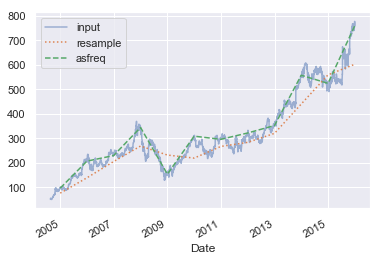

In [33]:
goog.plot(alpha=0.5, style='-')
goog.resample('BA').mean().plot(style=':')
goog.asfreq('BA').plot(style='--')
plt.legend(['input', 'resample', 'asfreq'], loc='upper left')

Notice the difference: at each point, resamples reports the average of the previous year, while asfreq reports the value at the end of the year.

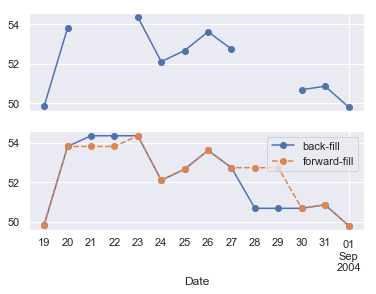

In [51]:
fig, ax = plt.subplots(2, sharex=True)
data = goog.iloc[:10]
data.asfreq('D').plot(ax=ax[0], marker='o')
data.asfreq('D', method='bfill').plot(ax=ax[1], style='-o')
data.asfreq('D', method='ffill').plot(ax=ax[1], style='--o')
ax[1].legend(['back-fill', 'forward-fill'], loc='upper right')

**Time-shifts**  
Another common time series-specific operation is shifting of data in time. Pandas has two closely related methods for computing this: shift() and tshift(). In short, the difference between them is that shift() shifts the **data**, while tshift() shifts the **index**.

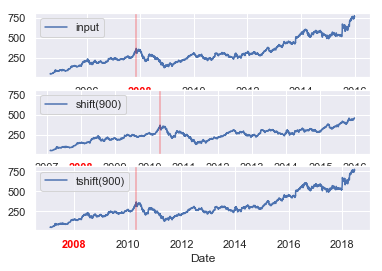

In [58]:
fig, ax = plt.subplots(3, sharey=True)
# apply a frequency to the data
goog = goog.asfreq('D', method='pad')
goog.plot(ax=ax[0])
goog.shift(900).plot(ax=ax[1])
goog.tshift(900).plot(ax=ax[2])
# legends and annotations
local_max = pd.to_datetime('2007-11-05')
offset = pd.Timedelta(900, 'D')
ax[0].legend(['input'], loc=2)
ax[0].get_xticklabels()[2].set(weight='heavy', color='red')
ax[0].axvline(local_max, alpha=0.3, color='red')

ax[1].legend(['shift(900)'], loc=2)
ax[1].get_xticklabels()[2].set(weight='heavy', color='red')
ax[1].axvline(local_max + offset, alpha=0.3, color='red')

ax[2].legend(['tshift(900)'], loc=2)
ax[2].get_xticklabels()[1].set(weight='heavy', color='red')
ax[2].axvline(local_max + offset, alpha=0.3, color='red')

Text(0,0.5,'% Return on Investment')

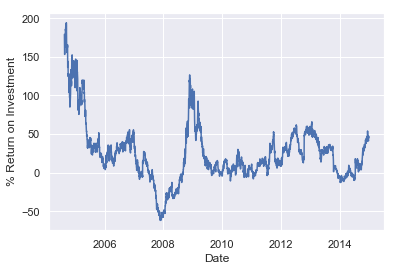

In [64]:
ROI = 100 * (goog.shift(-365) / goog - 1)
ROI.plot()
plt.ylabel('% Return on Investment')

**Rolling windows**

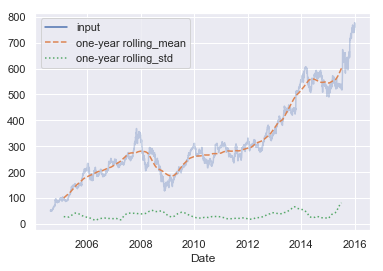

In [68]:
rolling = goog.rolling(365, center=True)
data = pd.DataFrame({'input': goog, 'one-year rolling_mean': rolling.mean(), 'one-year rolling_std': rolling.std()})
ax = data.plot(style=['-', '--', ':'])
ax.lines[0].set_alpha(0.3)

As with group-by operations, the aggregate() and apply() methods can be used for custom rolling computations.

**Example: Visualizing Seattle Bicycle Counts**

In [72]:
data = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
data.columns = ['West', 'East']
data['Total'] = data.eval('West + East')
data.dropna().describe()

In [74]:
%matplotlib inline
import seaborn
seaborn.set()

Text(0,0.5,'Hourly Bicycle Count')

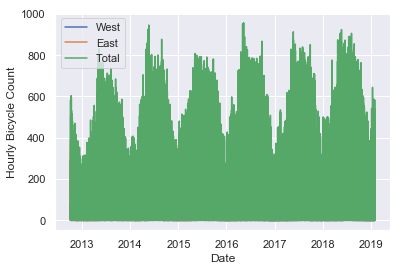

In [75]:
data.plot()
plt.ylabel('Hourly Bicycle Count')

Text(0,0.5,'Weekly bicycle count')

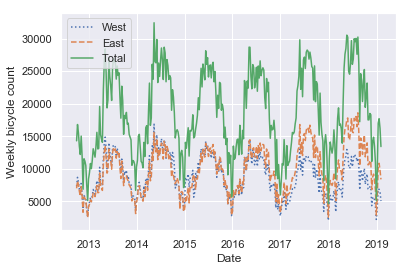

In [76]:
weekly = data.resample('W').sum()
weekly.plot(style=[':', '--', '-'])
plt.ylabel('Weekly bicycle count')

Text(0,0.5,'mean hourly count')

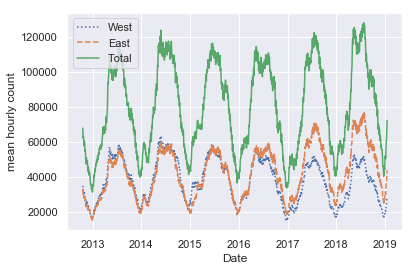

In [78]:
daily = data.resample("D").sum()
daily.rolling(30, center=True).sum().plot(style=[':', '--', '-'])
plt.ylabel('mean hourly count')

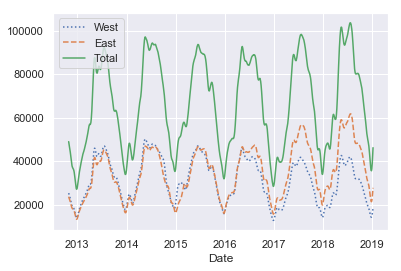

In [87]:
daily.rolling(50, center=True, win_type='gaussian').sum(std=10).plot(style=[':', '--', '-'])

**Digging into the data**

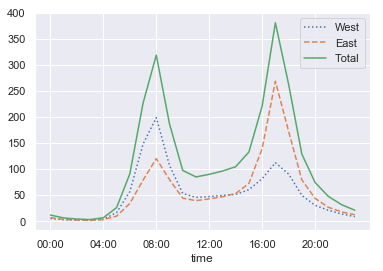

In [115]:
by_time = data.groupby(data.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=[':', '--', '-']);

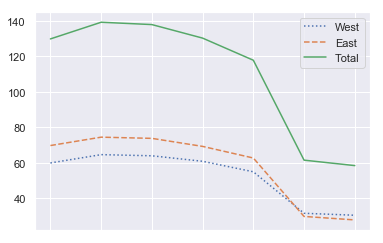

In [114]:
by_weekday = data.groupby(data.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=[':', '--', '-']);

In [116]:
weekend = np.where(data.index.weekday < 5, 'Weekday', 'Weekend')
by_time = data.groupby([weekend, data.index.time]).mean()

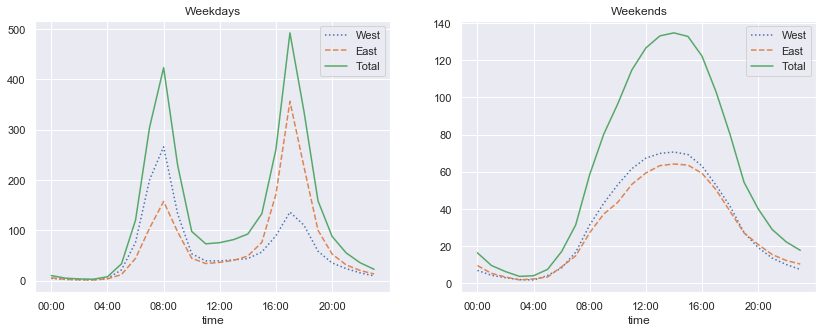

In [121]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, style=[':', '--', '-'])
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, style=[':', '--', '-']);
